#### Tree Questions

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
import statsmodels.api as sm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR, 
                          plot_tree, 
                          export_text)
from sklearn.ensemble import (RandomForestClassifier as RFC,GradientBoostingRegressor as GBR, RandomForestRegressor as RF)
from sklearn.metrics import (accuracy_score, 
                             log_loss)
from ISLP.bart import BART
from mpl_toolkits.mplot3d import Axes3D


#### Question 1
- Random Forest on `maxFeatures` & `n_estimators`

In [17]:
data = load_data('Boston')
x = data.drop(columns='medv')
y = data['medv']
x = sm.add_constant(x)

cv = skm.ShuffleSplit(n_splits = 5, test_size = 0.2, random_state=0)

# Range of values
max_features = np.arange(1, x.shape[1] + 1)
estimators = np.arange(100,1500, 100)
rss_vals = np.zeros((len(max_features), len(estimators)))

for features in max_features : 
    for estimator in estimators : 
        for train_idx, test_idx in cv.split(x) : 
            x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
            x_test, y_test = x.iloc[test_idx], y.iloc[test_idx]
            
            # Fitting
            rf = RF(n_estimators=estimator, max_features=features)
            rf.fit(x_train, y_train)
            y_pred = rf.predict(x_test)
            rss_vals[features-1, estimator//100 - 1] += ((y_pred - y_test) ** 2).sum()

        rss_vals[features-1, estimator//100 - 1] /= cv.get_n_splits()
        print(f"Testing Done for {features} features and {estimator} estimators")

Testing Done for 1 features and 100 estimators
Testing Done for 1 features and 200 estimators
Testing Done for 1 features and 300 estimators
Testing Done for 1 features and 400 estimators
Testing Done for 1 features and 500 estimators
Testing Done for 1 features and 600 estimators
Testing Done for 1 features and 700 estimators
Testing Done for 1 features and 800 estimators
Testing Done for 1 features and 900 estimators
Testing Done for 1 features and 1000 estimators
Testing Done for 1 features and 1100 estimators
Testing Done for 1 features and 1200 estimators
Testing Done for 1 features and 1300 estimators
Testing Done for 1 features and 1400 estimators
Testing Done for 2 features and 100 estimators
Testing Done for 2 features and 200 estimators
Testing Done for 2 features and 300 estimators
Testing Done for 2 features and 400 estimators
Testing Done for 2 features and 500 estimators
Testing Done for 2 features and 600 estimators
Testing Done for 2 features and 700 estimators
Testing 

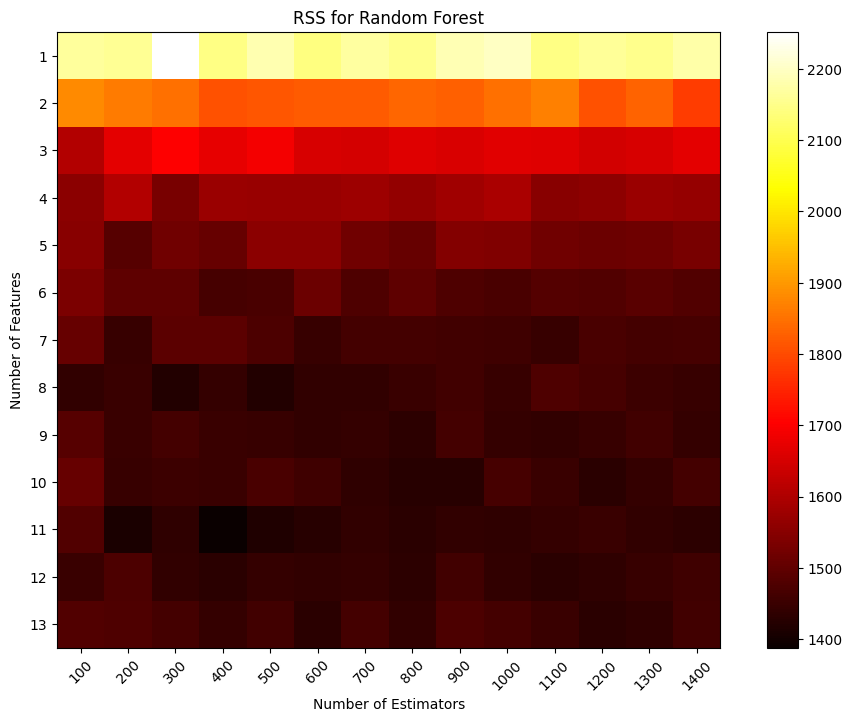

1387.6996301750012

In [21]:
# Plotting
plt.figure(figsize=(12, 8))
plt.imshow(rss_vals, interpolation='nearest', cmap=plt.cm.hot)
plt.colorbar()
plt.xlabel('Number of Estimators')
plt.ylabel('Number of Features')
plt.title('RSS for Random Forest')
plt.xticks(np.arange(len(estimators)), estimators)
plt.yticks(np.arange(len(max_features)), max_features)
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

# Best parameters
best_idx = np.argmin(rss_vals)
best_idx 

In [94]:
import plotly.graph_objects as go

# Create meshgrid for 3D surface
X, Y = np.meshgrid(estimators, max_features)

# Create interactive 3D surface plot
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=rss_vals)])

# Update layout
fig.update_layout(
    title='Interactive 3D Visualization of RSS Values',
    scene=dict(
        xaxis_title='Number of Estimators',
        yaxis_title='Number of Features',
        zaxis_title='RSS Value'
    ),
    width=1000,
    height=800
)

# Add hover template
fig.update_traces(hovertemplate='Estimators: %{x}<br>Features: %{y}<br>RSS: %{z}<extra></extra>')

# Add download buttons
fig.show(config={'toImageButtonOptions': {'format': 'png', 'filename': 'rss_3d_plot'},
                'displaylogo': False,
                'modeBarButtonsToAdd':['downloadhtml']})

#### Question 2
- Carseats dataset and use `Sales` as quantitative response variable

In [32]:
data = load_data('Carseats')
cv = skm.ShuffleSplit(n_splits = 1, test_size = 0.3, random_state=0)
x = data.drop(columns='Sales')
x["Urban"]  = np.where(x["Urban"] == "Yes", 1, 0)
x["US"]  = np.where(x["US"] == "Yes", 1, 0)
x = pd.get_dummies(x, drop_first=True)
x["ShelveLoc_Good"] = np.where(x["ShelveLoc_Good"] == "True", 1, 0)
x["ShelveLoc_Medium"] = np.where(x["ShelveLoc_Medium"] == "True", 1, 0)
y = data['Sales']
x = sm.add_constant(x)
x.head()

,const,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Good,ShelveLoc_Medium
0,1.0,138,73,11,276,120,42,17,1,1,0,0
1,1.0,111,48,16,260,83,65,10,1,1,0,0
2,1.0,113,35,10,269,80,59,12,1,1,0,0
3,1.0,117,100,4,466,97,55,14,1,1,0,0
4,1.0,141,64,3,340,128,38,13,1,0,0,0


In [34]:
train_idx, test_idx = next(cv.split(x))
x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
y_test = y.iloc[test_idx]
x_test = x.iloc[test_idx]

# Fitting
max_depth = np.arange(1, 11)

for depth in max_depth : 
    dt = DTR(max_depth=depth)
    dt.fit(x_train, y_train)
    y_pred = dt.predict(x_test)
    rss = np.mean((y_pred - y_test) ** 2)
    print(f"RSS for depth {depth} : {rss}")



RSS for depth 1 : 6.193522783011738
RSS for depth 2 : 5.97078216899392
RSS for depth 3 : 6.1541232235938805
RSS for depth 4 : 6.466964057087536
RSS for depth 5 : 6.809382007542687
RSS for depth 6 : 6.811311018281704
RSS for depth 7 : 7.632459660713405
RSS for depth 8 : 7.6080910750038315
RSS for depth 9 : 8.37708896379846
RSS for depth 10 : 8.334771772845556


We will be going with `depth` = 2. Test MSE is around 5.97.

In [56]:
# Tree Pruning
dt = DTR(max_depth=2)
pruning = dt.cost_complexity_pruning_path(x_train, y_train)
kfold = skm.ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
alpha = pruning.ccp_alphas
grid = skm.GridSearchCV(dt, {"ccp_alpha": alpha}, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(x, y)
print(f"Best alpha : {grid.best_params_}")
print(f"Best RSS : {-grid.best_score_}")

Best alpha : {'ccp_alpha': 0.38799268596327363}
Best RSS : 6.306024924121663


Tree pruning doesn't help to improve the RSS, it does definetly worsen it.

In [72]:
# Bagging
estimators = np.arange(100, 1000, 100)

for estimator in estimators : 
    bag = RF(n_estimators=estimator, max_features=x.shape[1])
    bag.fit(x_train, y_train)
    y_pred = bag.predict(x_test)
    rss = np.mean((y_pred - y_test) ** 2)
    print(f"RSS for {estimator} estimators : {rss}")

# 300 Estimators seems to be the right one



RSS for 100 estimators : 4.971652086583333
RSS for 200 estimators : 4.896542191854168
RSS for 300 estimators : 4.8445321301574085
RSS for 400 estimators : 4.873734201114583
RSS for 500 estimators : 4.845313934490006
RSS for 600 estimators : 4.853444127965285
RSS for 700 estimators : 4.90065623661395
RSS for 800 estimators : 4.875421623429694
RSS for 900 estimators : 4.873433630335399


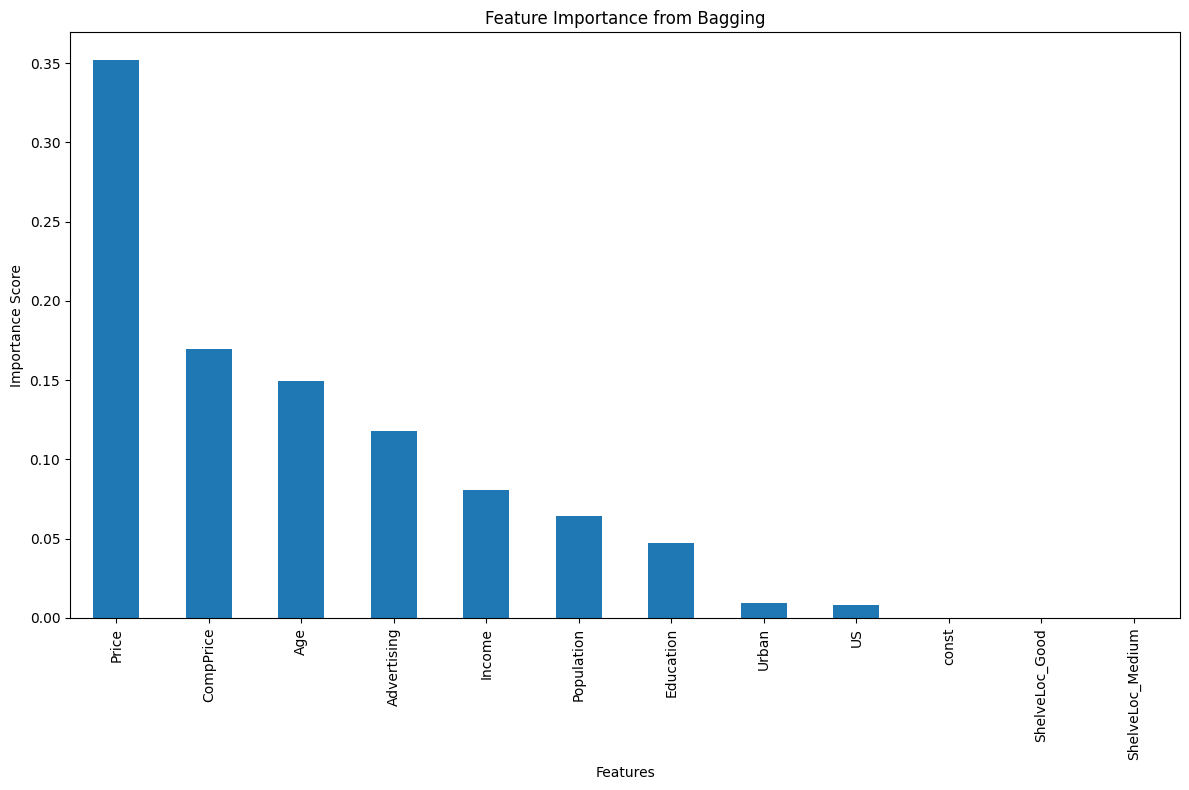

In [71]:
# Feature Importance
bag = RF(n_estimators=300, max_features=x.shape[1])
bag.fit(x_train, y_train)
importance = bag.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Bagging')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

RSS for Random Forest : 4.761317981314814


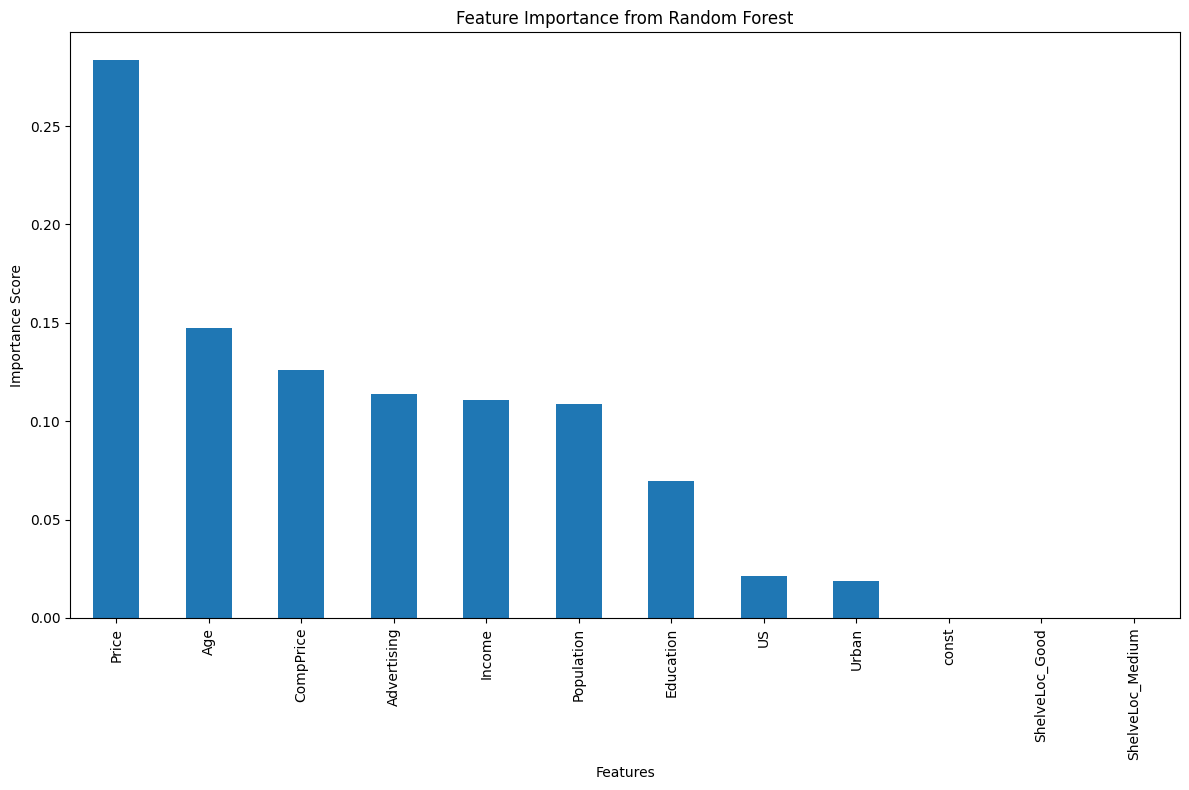

In [75]:
# Random Forest
max_feat = int(np.sqrt(x.shape[1]))
rf = RF(n_estimators=300, max_features=max_feat)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"RSS for Random Forest : {rss}")

# Feature Importance
importance = rf.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

RSS for Gradient Boosting : 4.966749337466965


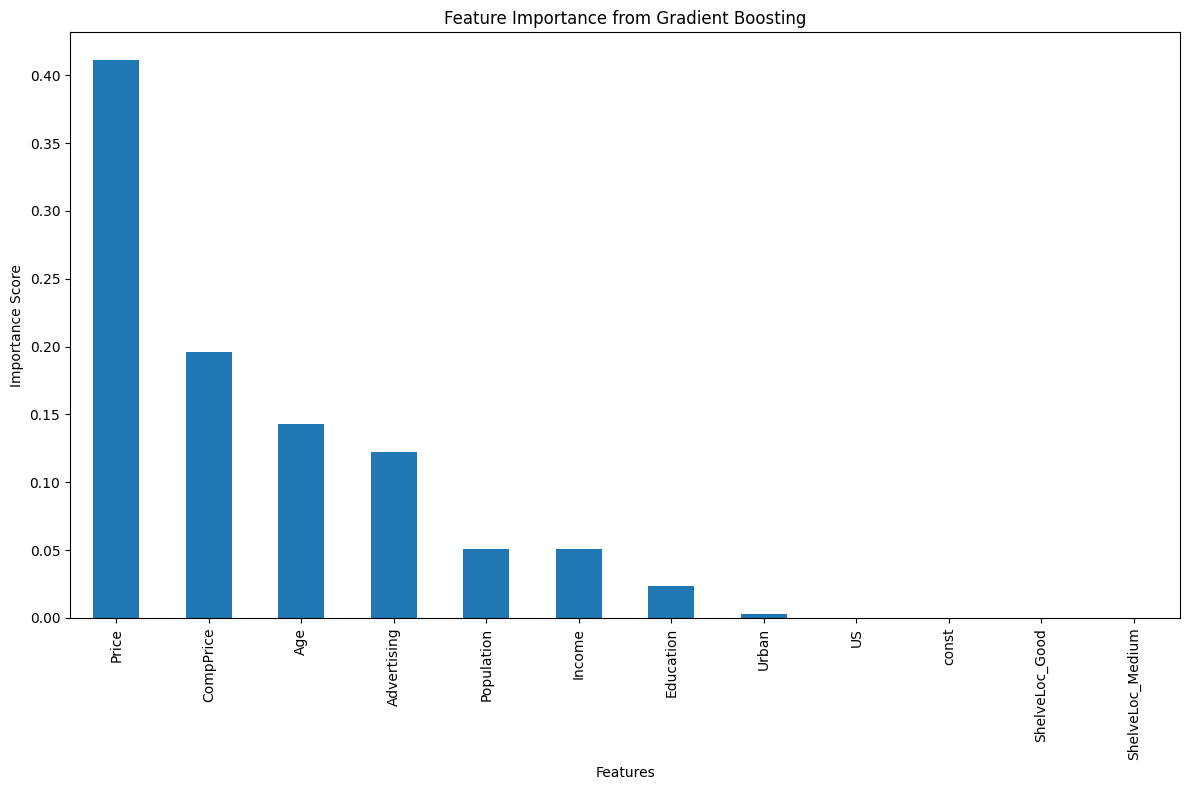

In [84]:
# Gradient Boosting
gb = GBR(n_estimators=300, learning_rate=0.03, max_depth=max_feat, random_state=0)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"RSS for Gradient Boosting : {rss}")

# Feature Importance
importance = gb.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Gradient Boosting')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


RSS for BART : 4.085473266888379


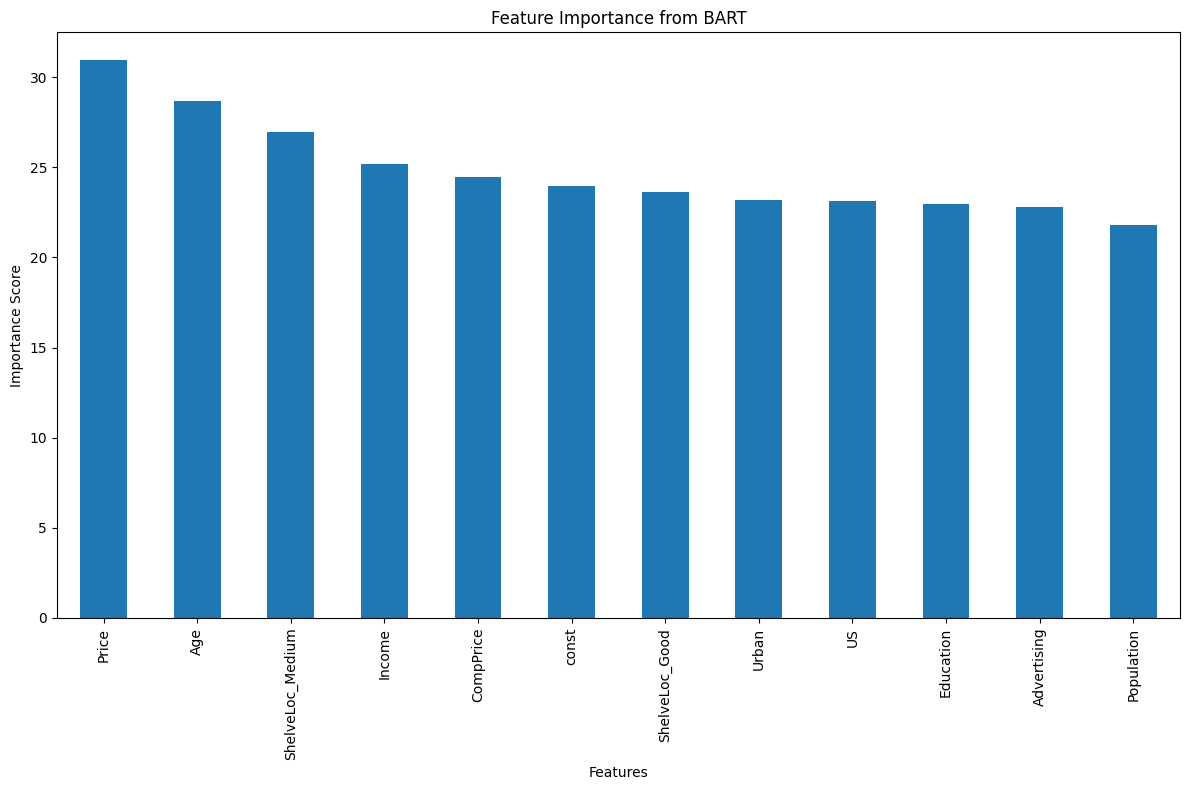

In [91]:
# BART
bart = BART(burnin=5, ndraw=15, random_state=0)
bart.fit(x_train, y_train)
y_pred = bart.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"RSS for BART : {rss}")

# Feature Importance
importance = bart.variable_inclusion_.mean(0)
var = pd.Series(importance, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
var.plot(kind='bar')
plt.title('Feature Importance from BART')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

Some how BART performs better than Random Forest, Gradient Boosting and Other methods. Need to learn how does it do it and what is happening in the hood because for an ensemble method it is very powerful then.